In [20]:
from keras.api.applications import EfficientNetB0
from keras import layers
import keras
import tensorflow
import numpy as np

In [11]:
BATCH_SIZE = 32
# B0 - 224x224
# B3 - 300x300
RESOLUTION = 224

realwaste = keras.utils.image_dataset_from_directory(
    "./data/realwaste",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=BATCH_SIZE
)

trashnet = keras.utils.image_dataset_from_directory(
    "./data/trashnet",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=BATCH_SIZE
)

Found 3587 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.


In [12]:
def split(dataset, train_pct):
        size = len(list(dataset.as_numpy_iterator()))
        train = dataset.take(int(train_pct * size))
        validation = dataset.skip(int(train_pct * size))
        return train, validation

training_dataset, validation_dataset = split(realwaste, 0.8)

In [13]:
augmentation_layers = [
    # Lighting variations
    layers.RandomBrightness(factor=(-0.2, 0.2)),
    # Blurring
    layers.GaussianNoise(stddev=0.2),
    # Distortions
    layers.RandomRotation(factor=0.1, fill_mode='nearest'),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),
    # Color variations
    layers.RandomContrast(factor=(0.8, 1.2)),
]

def augment(image):
    for layer in augmentation_layers:
        image = layer(image)
    return image

In [14]:
NUM_CLASSES = 6

def preprocess_augment(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    image = augment(image)
    return image, label

def resize(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, label

# Preprocess training
training_dataset = training_dataset.map(preprocess_augment, num_parallel_calls=tensorflow.data.AUTOTUNE)
training_dataset = training_dataset.prefetch(tensorflow.data.AUTOTUNE)

# Preprocess validation & test
validation_dataset = validation_dataset.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)

test_dataset = trashnet.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)

In [15]:
inputs = layers.Input(shape=(RESOLUTION, RESOLUTION, 3))
model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze layers so we can train the top layers
model.trainable = False

# Recreate top layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile model
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 648ms/step - accuracy: 0.7763 - loss: 0.7417 - val_accuracy: 0.8119 - val_loss: 0.6257
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 641ms/step - accuracy: 0.7553 - loss: 0.7715 - val_accuracy: 0.8147 - val_loss: 0.5671
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 641ms/step - accuracy: 0.7509 - loss: 0.7854 - val_accuracy: 0.8091 - val_loss: 0.6033
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.7473 - loss: 0.7894 - val_accuracy: 0.8105 - val_loss: 0.5609
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 644ms/step - accuracy: 0.7687 - loss: 0.7279 - val_accuracy: 0.8246 - val_loss: 0.5425
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.7588 - loss: 0.7250 - val_accuracy: 0.8232 - val_loss: 0.5524
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.7734 - loss: 0.7206 - val_accuracy: 0.8133 - val_loss: 0.5830
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 641ms/step - accuracy: 0.7689 - loss: 0.7476 - val_accu

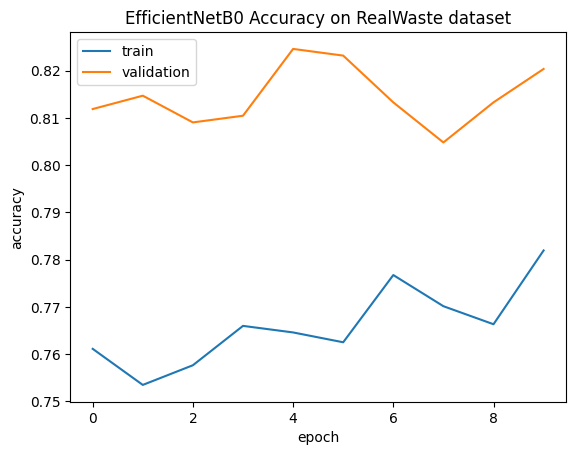

In [29]:
import matplotlib.pyplot as plt

epochs = 10
trained = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, shuffle=True)

def plot_results(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("EfficientNetB0 Accuracy on RealWaste dataset")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_results(trained)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 670ms/step - accuracy: 0.7728 - loss: 0.7165 - val_accuracy: 0.8388 - val_loss: 0.5137
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 641ms/step - accuracy: 0.8026 - loss: 0.6145 - val_accuracy: 0.8274 - val_loss: 0.5500
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.7873 - loss: 0.6967 - val_accuracy: 0.8317 - val_loss: 0.5221
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 640ms/step - accuracy: 0.7837 - loss: 0.6812 - val_accuracy: 0.8204 - val_loss: 0.5518
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 640ms/step - accuracy: 0.7821 - loss: 0.7429 - val_accuracy: 0.8331 - val_loss: 0.5099


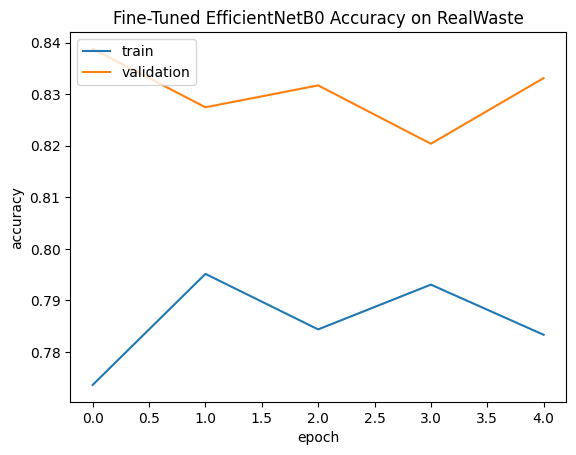

In [30]:
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 5
unfrozen_train = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, shuffle=True)

def plot_tuned(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("Fine-Tuned EfficientNetB0 Accuracy on RealWaste")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_tuned(unfrozen_train)

In [31]:
# Evaluate on TrashNet
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print("Initial Test on TrashNET")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 469ms/step - accuracy: 0.6287 - loss: 1.7305
Initial Test on TrashNET
Test Accuracy: 0.6403
Test Loss: 1.6703
